# 2023-06-05, Day 1

An introduction to the course and a re-introduction to single cell transcriptomics.

## Presentation:

- Lowering costs and improving quality made sequencing an increasingly attractive option for bio research.
- central dogma of molecular biology allows approximation of using mRNA as a proxy for cell type/state/function.
- bulk methods let us capture overall expression in group of cells; limited by what we can successfully dissect.
- modern techniques to isolate RNA from single cells - microfluidics as an example.
- what does single-cell allow that bulk/other techniques don't? Why use it in the first place?
- expression matrix as the entry point into scRNA-seq analysis.
- pairwise cell distances allow us to preserve the structure of expr matrix while reducing dimensionality (from `cells x genes` to `cells x cells`).
- what is the effect of the distance/similarity metric that we choose? How do we distill similarity/distance between cells to a single number?
- we can exploit the patterns in the cell-cell similarity matrix to find patterns:
- groups of cells that are more similar to each other than the rest. This can be nested (sub-groups and super-groups). What are the biological implications? What are some examples of nested similarity structures?
- patterns can be incredibly fine-grained - to the level of one cell in an organism (_C. elegans_ example).
- scRNA-seq is ready for production - contribution to COVID19/tumor research.
- patterns in the cell-cell similarity matrix can point towards dynamics as well:
- linear differentiation (think of examples)
- branching trajectories (what is a good example?)
- can bulk RNA-seq do the same? How does it compare?

## Introduction to scanpy and the AnnData structure

Please read the [tutorial](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) again. Basically, `AnnData` objects are a bag that contains multiple slots:
- gene expression is saved in a `cells x genes` matrix X
- cell metadata is saved in `obs`, a matrix of length `cells`
- gene metadata is saved in `var`, a matrix of length `genes`
- the unstructured dictionary `uns` holds all the things that don't fit in other places.

## getting started

We set out to get to know our data and exploit the patterns we learned to recognize in the pairwise cell similarity matrix:

In [1]:
# import important libraries
import scanpy as sc
import numpy as np
import pandas as pd

Read in the data:

In [2]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

2700 cells and 32378 genes.

In [4]:
adata.X

<2700x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 2286884 stored elements in Compressed Sparse Row format>

Analyze what this prompt means.

How full is our "sparse" matrix?

In [5]:
no_filled_cells = 2286884
no_total_cells = 2700 * 32738

percent_filled = no_filled_cells / no_total_cells
print(percent_filled)

0.025871894253591363


About 2%! Is that a lot/a little/normal?

To get to know our data we calculated the number of genes expressed in each cell. We arrived at the following definition:
- "expressed in each cell" means "more than one count"
- "total genes expressed" means "sum of all genes"

we figured out over which axis to sum up by looking at the `AnnData` diagrams.

In [6]:
adata.obs["n_genes_per_cell"] = np.sum(adata.X > 0, axis=1)

In [7]:
adata.obs

,n_genes_per_cell
index,
AAACATACAACCAC-1,781
AAACATTGAGCTAC-1,1352
AAACATTGATCAGC-1,1131
AAACCGTGCTTCCG-1,960
AAACCGTGTATGCG-1,522
...,...
TTTCGAACTCTCAT-1,1155
TTTCTACTGAGGCA-1,1227
TTTCTACTTCCTCG-1,622


We looked at the distribution of the total number of reads per cell. We asked ourselves what the distribution meant, what we could learn from the outliers, and what possible explanations we had for the shape of the curve and the outliers.

<Axes: >

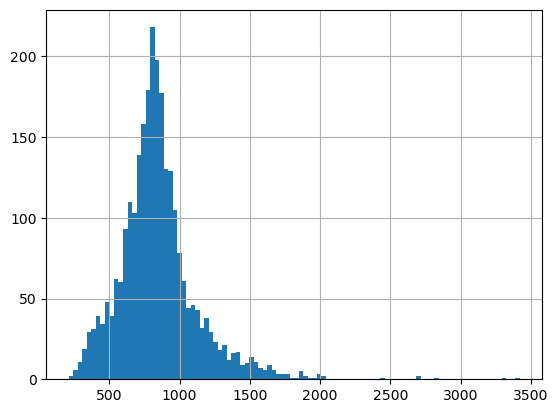

In [8]:
adata.obs["n_genes_per_cell"].hist(bins=100)

We then thought of a quality control measure for genes: number of total reads per gene. When we visualised it in a histogram, we realised that most genes were barely expressed (or not at all). We remembered that the matrix was extremely sparse, which meant that the most common number in the matrix must have been 0 by a large margin, making the plot less surprising. We also understood from the length of the x axis that some genes must be very highly expressed.

In [9]:
adata.var["n_reads_per_gene"] = np.array(np.sum(adata.X, axis=0))[0]

<Axes: >

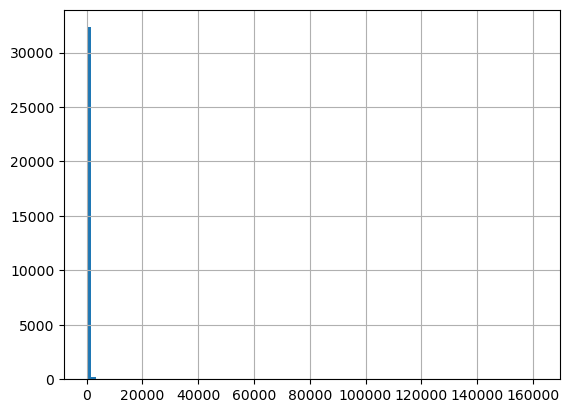

In [10]:
adata.var["n_reads_per_gene"].hist(bins=100)

We went back to the cells and calculated the number of reads per cell similarly to the number of genes per cell.

In [11]:
adata.obs["n_reads_per_cell"] = np.sum(adata.X, axis=1)

<Axes: >

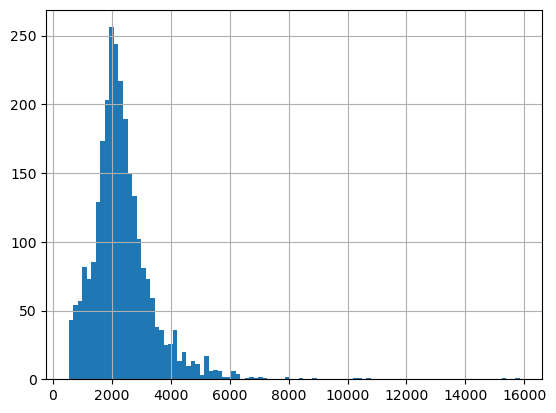

In [12]:
adata.obs["n_reads_per_cell"].hist(bins=100)

The resulting plot is very similar to the number of genes per cell. Why is that? Can we explain it using the histogram of reads per gene?

We also looked at the relationship between reads and genes per cell. We saw a very strong correlation between them. Do we think this is surprising or not? Why?

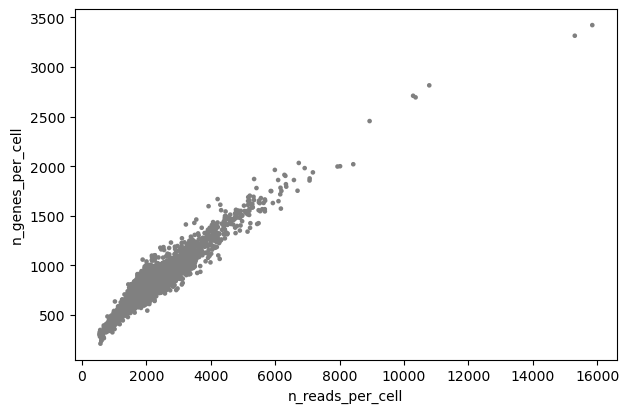

In [13]:
sc.pl.scatter(adata, "n_reads_per_cell", "n_genes_per_cell")

Going back to the reads-by-gene histogram, we asked ourselves which genes are so very highly expressed. We used one of `scanpy`'s functions to get that information.

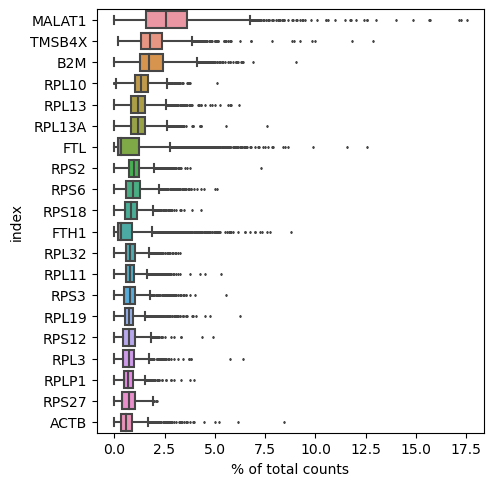

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

We realized that most of the genes are housekeeping. Does this surprise us? Why/why not?

We then calculated scanpy's QC metrics and noticed that it didn't calculate too many things that we didn't think of. We used its "pct counts in top 50 genes" as a coarse measure of quality (why? what's the rationale?) and tried to see if we found any relationship between number of counts and cell "quality".

In [15]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

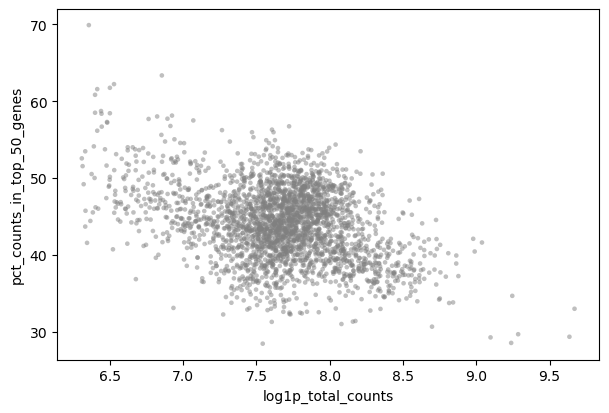

In [16]:
sc.pl.scatter(adata, "log1p_total_counts", "pct_counts_in_top_50_genes", alpha=0.5)

This result was a bit puzzling. We looked at the extremes of the distribution to try and make sense of it, by constructing statements like "cells with a lot of counts have less uninteresting genes". What was our conclusion? Why could this be happening? What are possible biological reasons for this?

In [18]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

In [19]:
interesting_genes = adata.var["dispersions_norm"] > 0

In [20]:
interesting = adata[:, interesting_genes]

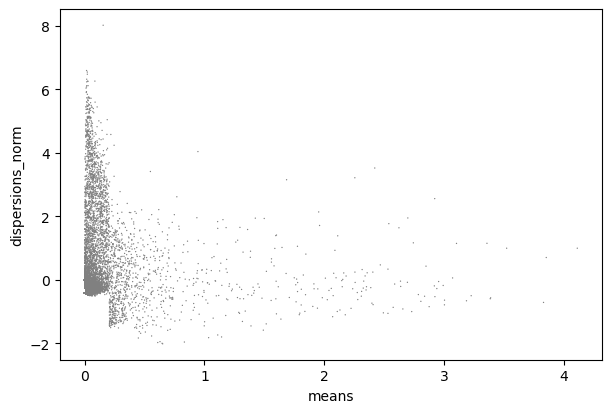

In [22]:
sc.pl.scatter(adata, "means", "dispersions_norm")

We looked at the scatter plot of average expression versus (normalised) dispersion. Again we interpreted the scatter plot by looking at the extremes and trying to figure out the overall shape of the distribution. What are genes with high average expression but low variance? What are genes with low average expression but high variance? What scenarios could we imagine that generate patterns like that, either in terms of matrices or in biological terms?

## Finding patterns

We put our pattern identification idea from the presentation to use: We calculate neighbours in the matrix using the raw count data, as it should work in theory.

In [23]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")
sc.pp.neighbors(adata, use_rep="X")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

We visualize using UMAP, but keep in mind that we shouldn't be using it for anything quantitative, really.

In [24]:
sc.tl.umap(adata)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


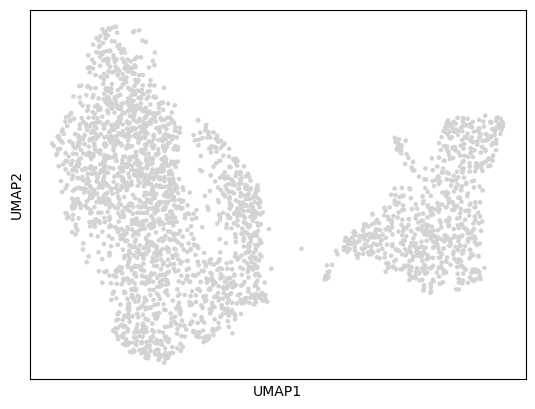

In [25]:
sc.pl.umap(adata)

In [26]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

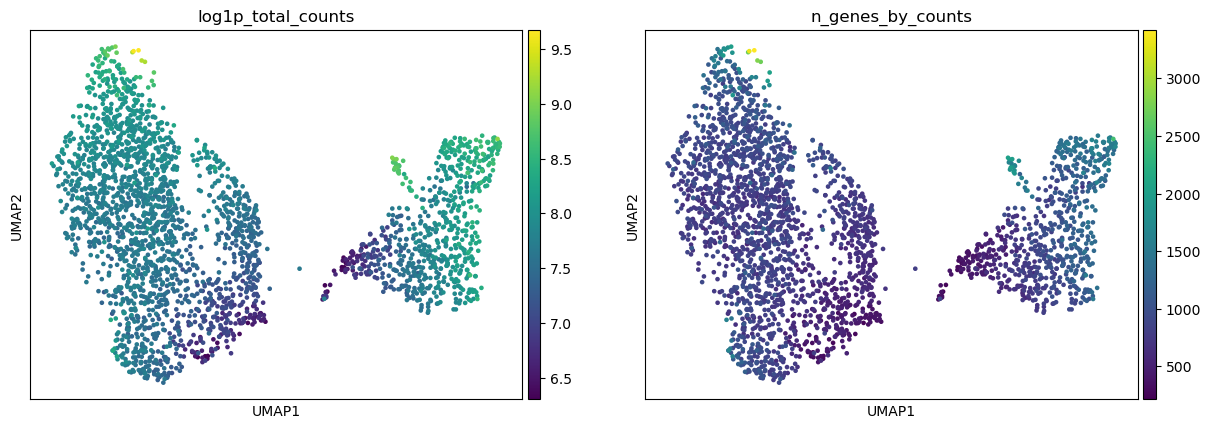

In [27]:
sc.pl.umap(adata, color=["log1p_total_counts", "n_genes_by_counts"])

There is a clear and pronounced gradient of increasing read counts. We went to the whiteboard and explored a toy example where we calculated Euclidean distances. We explained why not all distances are created equal and the accidental similarities the many shared zeros can cause. We tried normalizing gene expression by columns (genes) and then by rows (cells) in order to pretend that all cells are exactly the same size.

Now try with normalisation:

In [28]:
adata = sc.read_h5ad("/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/pbmc3k/pbmc3k_raw.h5ad")

In [29]:
adata.raw = adata

In [30]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=100)

In [31]:
sc.pp.neighbors(adata, use_rep="X")

In [32]:
sc.tl.umap(adata)

In [33]:
adata.X = adata.raw.X.copy()

In [34]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

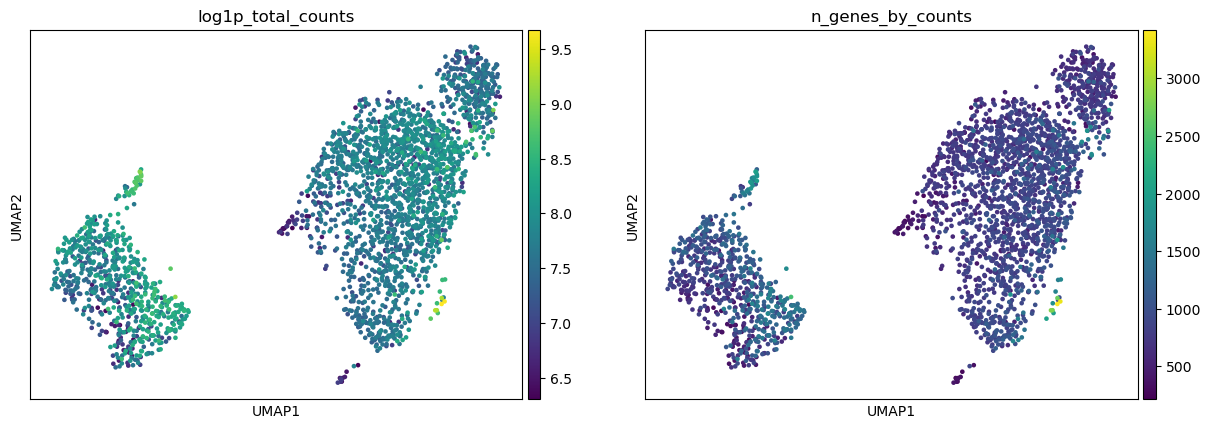

In [35]:
sc.pl.umap(adata, color=["log1p_total_counts", "n_genes_by_counts"])

## Homework

### Literature about normalisation

- Ronit: comparison of transformations.pdf
- Michelle: depth normalisation.pdf
- Noemi: noise models single-cell.pdf
- Antonia: PFlog1pPF.pdf
- Oliver: sctransform.pdf
- Mario: triumphs and limitations.pdf

### catch up with scanpy tutorials

for whoever didn't manage yet